In [144]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
import glob
from IPython.display import display

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import loss_functions as lf
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Inputs

---
1. Switch Delay
2. Reward weighting
3. Altered SD 

        - Agent SD
        - Movement SD
        - Reaction SD
        - Gamble SD

---
NOTE: I'm using the data for guess sd. Haven't been able to really fit this with realistic parameters of the model. 

- This is likely due to people's intended decision time changing, whereas in the model, it is all around a single decision time
---

# Select Exp1 or Exp2


In [145]:
EXPERIMENT = "Exp1"

# Initial Thangs


In [146]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}")
it = InitialThangs(EXPERIMENT)

# Pickle Data


In [147]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
    
model_path = Path(f'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}\\models')

model_description_dfs = list(model_path.glob(f"{EXPERIMENT}_model_descriptions*"))
model_parameter_dfs = list(model_path.glob(f"{EXPERIMENT}_model_parameters*"))

# with open(model_path / 'exp1_model_table.pkl', 'rb') as f:
#     model_df = dill.load(f)

# Overall Analysis of Models

## Get models

In [148]:
df_description = pd.read_pickle(model_description_dfs[-1])
df = pd.read_pickle(model_parameter_dfs[-1])

## Calculate number of unknown parameters and  BIC

In [149]:
# Count the number of unknowns/alterations were made to the model
df['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
n = group.exp_info.num_subjects
df['BIC'] = n*np.log(df['Loss']/n) + df['Parameters']*np.log(n)
df

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters,BIC
0,model0_2023_09_18_13_50_22,9.166158,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,4,-3.621353
1,model1_2023_09_18_13_50_23,5.864025,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,5,-9.559261
2,model2_2023_09_18_13_50_23,7.949396,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,-0.2,0.0,1.0,0.5,5,-3.474065
3,model3_2023_09_18_13_50_23,6.921337,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,-0.2,0.0,1.0,0.5,6,-3.248074
4,model4_2023_09_18_13_50_23,9.166158,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[0]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,5,-0.625620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,model251_2023_09_18_13_51_04,11.603739,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[0]]]","[[[50]], [[50]]]","[[[115]], [[50]]]",1.0,-0.2,0.0,1.0,0.5,3,-1.900902
252,model252_2023_09_18_13_51_05,9.176145,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.

In [150]:
# Count the number of unknowns/alterations were made to the model
df_description['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
n = group.exp_info.num_subjects
df_description['BIC'] = n*np.log(df_description['Loss']/n) + df_description['Parameters']*np.log(n)
df_description

,Model,Loss,Known_Switch_Delay,Known_Switch_SD,Known_Guess_SD,Known_Agent_SD,Known_RT_SD,Known_MT_SD,Known_Timing_SD,Win_Reward,Incorrect_Cost,Indecision_Cost,Parameters,BIC
0,model0_2023_09_18_13_50_22,9.166158,True,True,True,False,False,False,False,Normal,Normal,Normal,4,-3.621353
1,model1_2023_09_18_13_50_23,5.864025,True,True,False,False,False,False,False,Normal,Normal,Normal,5,-9.559261
2,model2_2023_09_18_13_50_23,7.949396,True,True,True,False,False,False,False,Normal,Less,Normal,5,-3.474065
3,model3_2023_09_18_13_50_23,6.921337,True,True,False,False,False,False,False,Normal,Less,Normal,6,-3.248074
4,model4_2023_09_18_13_50_23,9.166158,True,False,True,False,False,False,False,Normal,Normal,Normal,5,-0.625620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,model251_2023_09_18_13_51_04,11.603739,False,True,False,True,True,True,True,Normal,Less,Normal,3,-1.900902
252,model252_2023_09_18_13_51_05,9.176145,False,False,True,True,True,True,True,Normal,Normal,Normal,2,-9.591038
253,model253_2023_09_18_13_51_05,8.506852,False,False,False,True,True,True,True,Normal,Normal,Normal,3,-8.110010
254,model254_2023_09_18_13_51_05,11.537934,False,False,True,True,True,True,True,Normal,Less,Normal,3,-2.014644


## Calculate some paramter effectiveness metrics

### Mean loss for that parameter

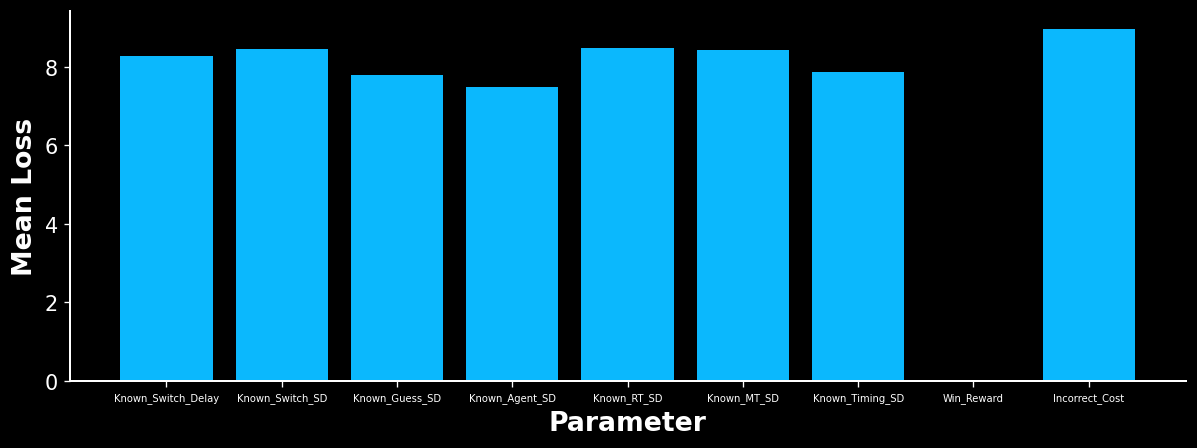

In [151]:
# Get the mean loss when that parameter is False
parameter_mean_loss = {}
for col in df_description.columns[2:11]: # Skipping 'Model', "Loss", "Parameters"
    if col in ['Win_Reward', 'Incorrect_Cost', 'Indecision_Cost']:
        dff = df_description[df_description[col].isin(['Less','Greater'])]
        parameter_mean_loss.update({col:dff['Loss'].mean()})
    else:
        dff = df_description[df_description[col] == False]
        parameter_mean_loss.update({col:dff['Loss'].mean()})
        
num_params = len(parameter_mean_loss.values())
xlocs = np.arange(0,num_params,1)
fig,ax = plt.subplots(dpi=120,figsize=(12,4))
ax.bar(xlocs, parameter_mean_loss.values()) 
ax.set_xticks(xlocs)
ax.set_xticklabels(parameter_mean_loss.keys(), fontsize=6)
ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Loss')
plt.show()

### Mean difference when that parameter is known versus unknown

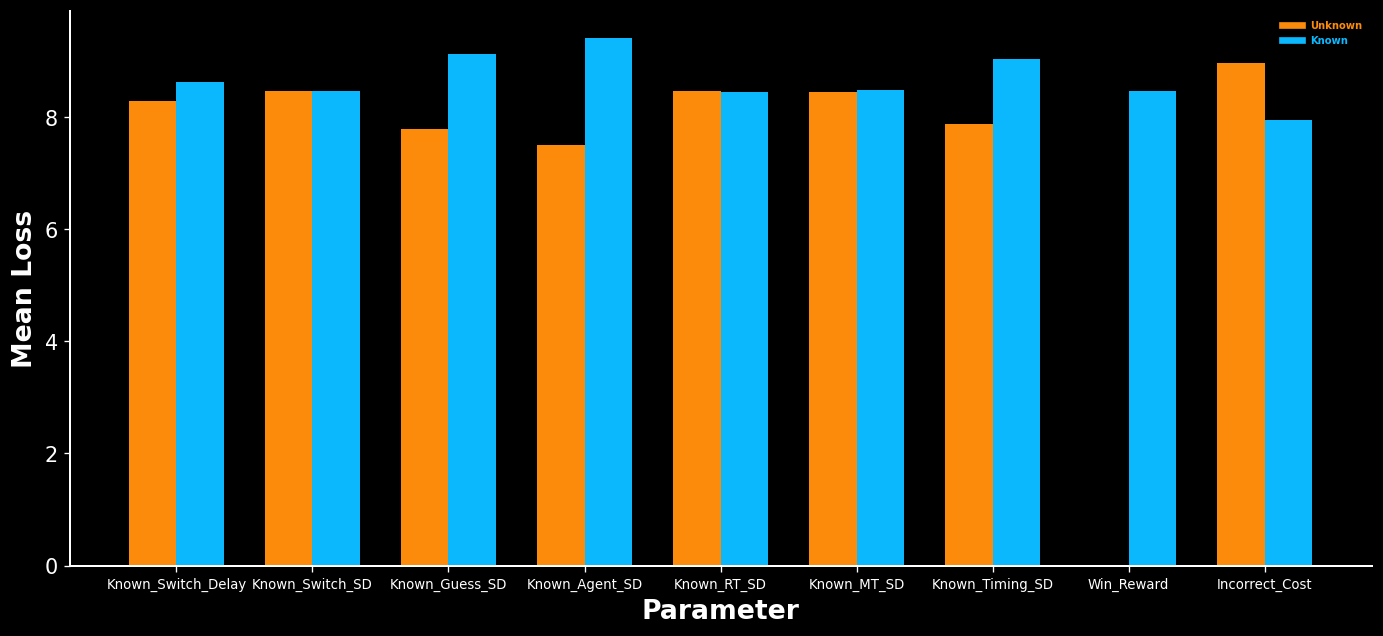

In [152]:
parameter_mean_loss_known = {}
parameter_mean_loss_unknown = {}
for col in df_description.columns[2:11]: # Skipping 'Model', "Loss", "Parameters"
    if col in ['Win_Reward', 'Incorrect_Cost', 'Indecision_Cost']:
        dff_unknown = df_description[df_description[col].isin(['Less','Greater'])]
        parameter_mean_loss_unknown.update({col:dff_unknown['Loss'].mean()})
        dff_known = df_description[df_description[col].isin(['Normal'])]
        parameter_mean_loss_known.update({col:dff_known['Loss'].mean()})
    else:
        dff_unknown = df_description[df_description[col] == False]
        parameter_mean_loss_unknown.update({col:dff_unknown['Loss'].mean()})
        dff_known = df_description[df_description[col] == True]
        parameter_mean_loss_known.update({col:dff_known['Loss'].mean()})
        
num_params = len(parameter_mean_loss_known.values())
xlocs = np.arange(0,num_params,1)
w,h = 14,6
bar_width = w*0.025
fig,ax = plt.subplots(dpi=120,figsize=(w,h))
ax.bar(xlocs+(0.5*bar_width), parameter_mean_loss_known.values(), width=bar_width, color=wheel.rak_blue) 
ax.bar(xlocs-(0.5*bar_width), parameter_mean_loss_unknown.values(),width=bar_width, color=wheel.rak_orange) 
ax.set_xticks(xlocs)
ax.set_xticklabels(parameter_mean_loss.keys(), fontsize=8)
ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Loss')
dv.custom_legend(ax,['Unknown', 'Known'], [wheel.rak_orange, wheel.rak_blue])
plt.show()

## Filter out Models

Minimal Loss Models

In [153]:
num_best_models = 5
best_models_df = df.nsmallest(num_best_models,'Loss')
best_models_description = df_description.nsmallest(num_best_models,'Loss')
best_models_description


,Model,Loss,Known_Switch_Delay,Known_Switch_SD,Known_Guess_SD,Known_Agent_SD,Known_RT_SD,Known_MT_SD,Known_Timing_SD,Win_Reward,Incorrect_Cost,Indecision_Cost,Parameters,BIC
105,model105_2023_09_18_13_50_40,5.403017,False,True,False,False,True,True,False,Normal,Normal,Normal,4,-14.192568
109,model109_2023_09_18_13_50_40,5.403017,False,False,False,False,True,True,False,Normal,Normal,Normal,5,-11.196836
9,model9_2023_09_18_13_50_24,5.449564,False,True,False,False,False,False,False,Normal,Normal,Normal,6,-8.029539
13,model13_2023_09_18_13_50_24,5.449564,False,False,False,False,False,False,False,Normal,Normal,Normal,7,-5.033806
41,model41_2023_09_18_13_50_29,5.651163,False,True,False,False,False,True,False,Normal,Normal,Normal,5,-10.298757


Minimal BIC Models

In [154]:
best_models_bic_df = df.nsmallest(5,'BIC')
best_models_bic_df_description = df_description.nsmallest(5,'BIC')
best_models_bic_df_description

,Model,Loss,Known_Switch_Delay,Known_Switch_SD,Known_Guess_SD,Known_Agent_SD,Known_RT_SD,Known_MT_SD,Known_Timing_SD,Win_Reward,Incorrect_Cost,Indecision_Cost,Parameters,BIC
97,model97_2023_09_18_13_50_39,5.842309,True,True,False,False,True,True,False,Normal,Normal,Normal,3,-15.624927
113,model113_2023_09_18_13_50_41,7.036957,True,True,False,False,True,True,True,Normal,Normal,Normal,2,-14.899664
225,model225_2023_09_18_13_51_00,7.171576,True,True,False,True,True,True,False,Normal,Normal,Normal,2,-14.520673
105,model105_2023_09_18_13_50_40,5.403017,False,True,False,False,True,True,False,Normal,Normal,Normal,4,-14.192568
241,model241_2023_09_18_13_51_03,8.523356,True,True,False,True,True,True,True,Normal,Normal,Normal,1,-14.062711


Single Parameter Models

In [155]:
mask = 'Parameters == 1 or Parameters==0'
single_parameter_models = df.query(mask)
single_parameter_models_description = df_description.query(mask)
display(single_parameter_models_description)
display(single_parameter_models)

,Model,Loss,Known_Switch_Delay,Known_Switch_SD,Known_Guess_SD,Known_Agent_SD,Known_RT_SD,Known_MT_SD,Known_Timing_SD,Win_Reward,Incorrect_Cost,Indecision_Cost,Parameters,BIC
112,model112_2023_09_18_13_50_41,9.514701,True,True,True,False,True,True,True,Normal,Normal,Normal,1,-11.862152
176,model176_2023_09_18_13_50_52,9.795400,True,True,True,True,False,True,True,Normal,Normal,Normal,1,-11.280655
208,model208_2023_09_18_13_50_57,9.863945,True,True,True,True,True,False,True,Normal,Normal,Normal,1,-11.141188
224,model224_2023_09_18_13_51_00,9.167126,True,True,True,True,True,True,False,Normal,Normal,Normal,1,-12.606436
240,model240_2023_09_18_13_51_02,10.034863,True,True,True,True,True,True,True,Normal,Normal,Normal,0,-13.793339
241,model241_2023_09_18_13_51_03,8.523356,True,True,False,True,True,True,True,Normal,Normal,Normal,1,-14.062711
242,model242_2023_09_18_13_51_03,12.408283,True,True,True,True,True,True,True,Normal,Less,Normal,1,-6.551628
244,model244_2023_09_18_13_51_03,10.034863,True,False,True,True,True,True,True,Normal,Normal,Normal,1,-10.797607
248,model248_2023_09_18_13_51_04,9.176145,False,True,True,True,True,True,True,Normal,Normal,Normal,1,-12.586771


,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters,BIC
112,model112_2023_09_18_13_50_41,9.514701,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1,-11.862152
176,model176_2023_09_18_13_50_52,9.795400,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[18.847560735762826]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1,-11.280655
208,model208_2023_09_18_13_50_57,9.863945,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[13.271339787182907]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1,-11.141188
224,model224_2023_09_18_13_51_00,9.167126,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1,-12.606436
240,model240_2023_09_18_13_51_02,10.034863,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,0,-13.793339
241,model241_2023_09_18_13_51_03,8.523356,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,1,-14.062711
242,model242_2023_09_18_13_51_03,12.408283,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74

## Run Models

In [156]:
models = {}
for index,row in single_parameter_models.iterrows():
    model  = ModelConstructor(
                        experiment=EXPERIMENT,
                        num_blocks=row.num_blocks,
                        num_timesteps=1800,
                        agent_means=row.agent_means,
                        agent_sds=row.agent_sds, #!
                        reaction_time=row.reaction_time,
                        movement_time=row.movement_time,
                        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
                        movement_sd=row.movement_sd,
                        timing_sd=row.timing_sd,
                        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
                        guess_switch_sd=row.guess_switch_sd, # This includes electromechanical delay sd and timing sd bc it's straight from data
                        electromechanical_delay=row.electromechanical_delay,
                        switch_cost_exists=True,
                        expected=True,
                        win_reward=row.win_reward,
                        incorrect_cost=row.incorrect_cost,
                        indecision_cost=row.indecision_cost,
                        round_num = 20
                    )
    models.update({row['Model']:model})

In [200]:
d1 = {'a':1,'b':3}
d2 = {'a':2,'b':2}
max_dict = {}
for (k1,v1),(k2,v2) in zip(d1.items(),d2.items()):
    if v1>v2:
        max_dict.update({k1:v1})
    else:
        max_dict.update({k2:v2})


In [201]:
max_dict

{'a': 2, 'b': 3}

# Plots

In [157]:
# line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange, wheel.pink]
save = False

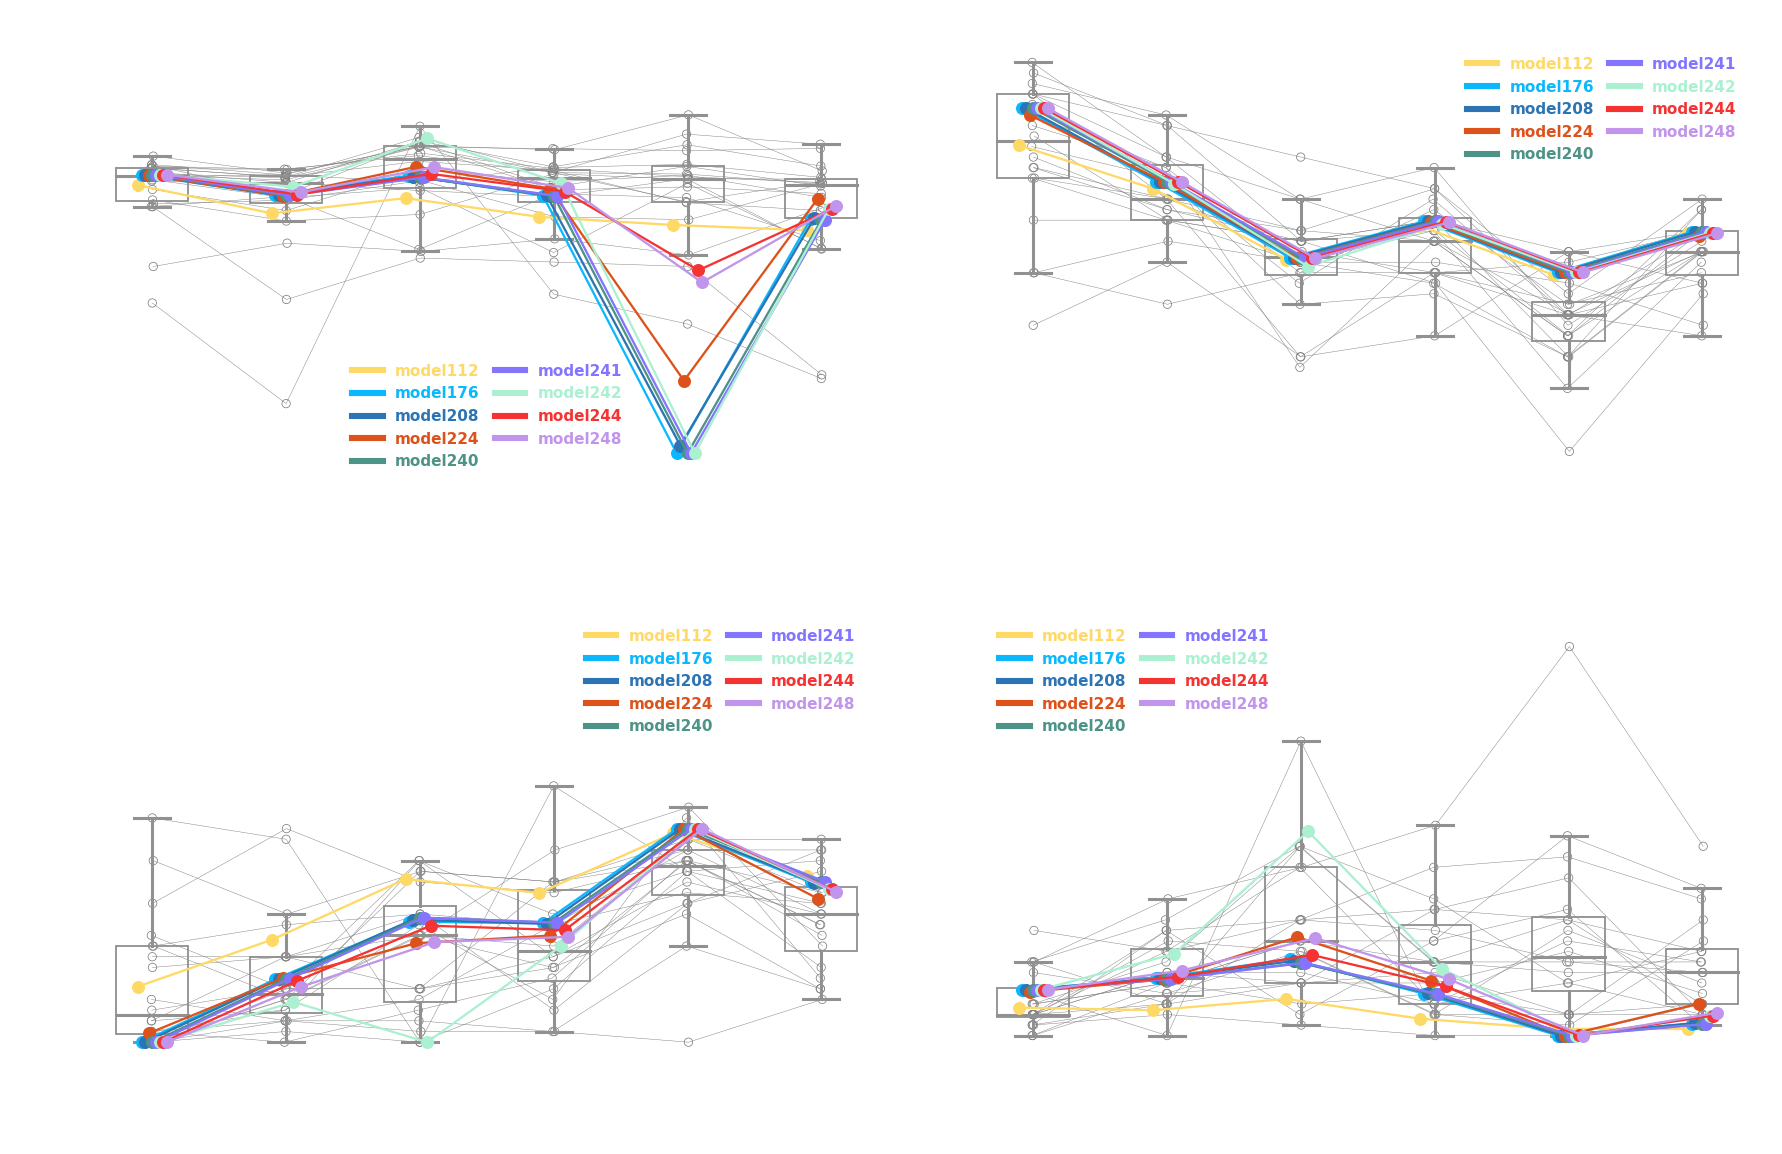

In [158]:
w, h = 16, 10

mult_w, div_w = 0.053, 2.3
div_h = 2.5
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 10

metrics = [
    np.nanmedian(group.movement_metrics.movement_onset_times("task"), axis=2),
    group.score_metrics.score_metric("wins") / group.exp_info.num_task_trials * 100,
    group.score_metrics.score_metric("incorrects") / group.exp_info.num_task_trials * 100,
    group.score_metrics.score_metric("indecisions") / group.exp_info.num_task_trials * 100,
]
ylocs = [np.arange(400, 1601, 200)] + [np.arange(0, 101, 25)] * 3
ylabels = ["Time (ms)", "Wins (%)", "Incorrects (%)", "Indecisions (%)"]
titles = ["Median Movement Onset Time", "Wins", "Incorrects", "Indecisions"]
model_labels = [name.split("_")[0] for name in models.keys()]  # Get the model names, only up to the number, ignore date

fig = dv.Figure(figsize=(w, h), dpi=110)
ax1 = fig.add_panel(dim=(w * mult_w, 0.0, w / div_w, h / div_h))
ax2 = fig.add_panel(dim=(w / div_w + 1.9, 0.0, w / div_w, h / div_h))
ax3 = fig.add_panel(dim=(w * mult_w, 5.2, w / div_w, h / div_h))
ax4 = fig.add_panel(dim=(w / div_w + 1.9, 5.2, w / div_w, h / div_h))
axs = [ax1, ax2, ax3, ax4]
model_data = [
    [model.results.get_metric(model.player_behavior.wtd_leave_time, metric_type="true", decision_type="optimal") for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_win, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_incorrect, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
    [model.results.get_metric(model.score_metrics.prob_indecision, metric_type="true", decision_type="optimal") * 100 for model in models.values()],
]

for j in range(len(model_data)):
    pf.multiple_models_boxplot_v2(
        ax=axs[j],
        data=metrics[j],
        model_data=model_data[j],
        labels=model_labels,
        show_boxplot=True,
        colors=wheel.grey,
        linestyles=None,
        line_colors=None,
        xlocs=xlocs,
        ylocs=ylocs[j],
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel=ylabels[j],
        title=titles[j],
        legend_fontsize=legend_fontsize,
        title_fontsize=20,
    )
fig.remove_figure_borders()
# plt.suptitle(suptitles[i], y=1.1, fontsize = 30)

# Base Model

In [159]:
df_description.head()

,Model,Loss,Known_Switch_Delay,Known_Switch_SD,Known_Guess_SD,Known_Agent_SD,Known_RT_SD,Known_MT_SD,Known_Timing_SD,Win_Reward,Incorrect_Cost,Indecision_Cost,Parameters,BIC
0,model0_2023_09_18_13_50_22,9.166158,True,True,True,False,False,False,False,Normal,Normal,Normal,4,-3.621353
1,model1_2023_09_18_13_50_23,5.864025,True,True,False,False,False,False,False,Normal,Normal,Normal,5,-9.559261
2,model2_2023_09_18_13_50_23,7.949396,True,True,True,False,False,False,False,Normal,Less,Normal,5,-3.474065
3,model3_2023_09_18_13_50_23,6.921337,True,True,False,False,False,False,False,Normal,Less,Normal,6,-3.248074
4,model4_2023_09_18_13_50_23,9.166158,True,False,True,False,False,False,False,Normal,Normal,Normal,5,-0.625620


In [181]:

# model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Agent_SD==False and Known_Guess_SD==False and Known_Switch_Delay==False and Incorrect_Cost == "Less" and Parameters==4)')['Model'])
# model_names_from_df = list(df_description.query('Parameters == 0')['Model'])
base_model_df = df[df['Model'].isin(model_names_from_df)]
base_model_df = base_model_df.sort_values('Parameters')
model_names = ['Theoretical Optimal', 'Theoretical Optimal\n(Not Accounting for Switch Delay)', "Blah", "Blah"]
display(base_model_df)
models = {}
for i, (index, row) in enumerate(base_model_df.iterrows()):
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certaimodel_names_from_df = list(df_description.query('Parameters == 0 or (Incorrect_Cost=="Less" and Known_Switch_Delay==False and Parameters==2)')['Model'])
n than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd, # This includes electromechanical delay sd and timing sd bc it's straight from data
        # guess_sd=row.guess_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=True,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 23
    )
    models.update({model_names[i]:model})

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters,BIC
240,model240_2023_09_18_13_51_02,10.034863,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[65]]]","[[[50]], [[50]]]","[[[115]], [[115]]]",1.0,0.0,0.0,1.0,0.5,0,-13.793339
250,model250_2023_09_18_13_51_04,11.537934,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,3,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[65]], [[65]]]","[[[74.73005247543776], [115.3949109228306], [9...",True,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[65]], [[0]]]","[[[50]], [[50]]]","[[[115]], [[50]]]",1.0,-0.2,0.0,1.0,0.5,2,-5.010376


In [182]:
SHOW_BOXPLOTS = True
SHOW_MODELS = True
w,h = 10,6
mult_w, div_w = 0.9,1.1
div_h = 1.1
bw = 0.4*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width

Movement Onset

[array([1240.55652025, 1213.71706618, 1339.73550781, 1226.15577082,
        481.        , 1154.15754576]), array([1240.55652705, 1232.89937032, 1339.73970617, 1279.87751444,
       1132.05550748, 1233.58188464])]


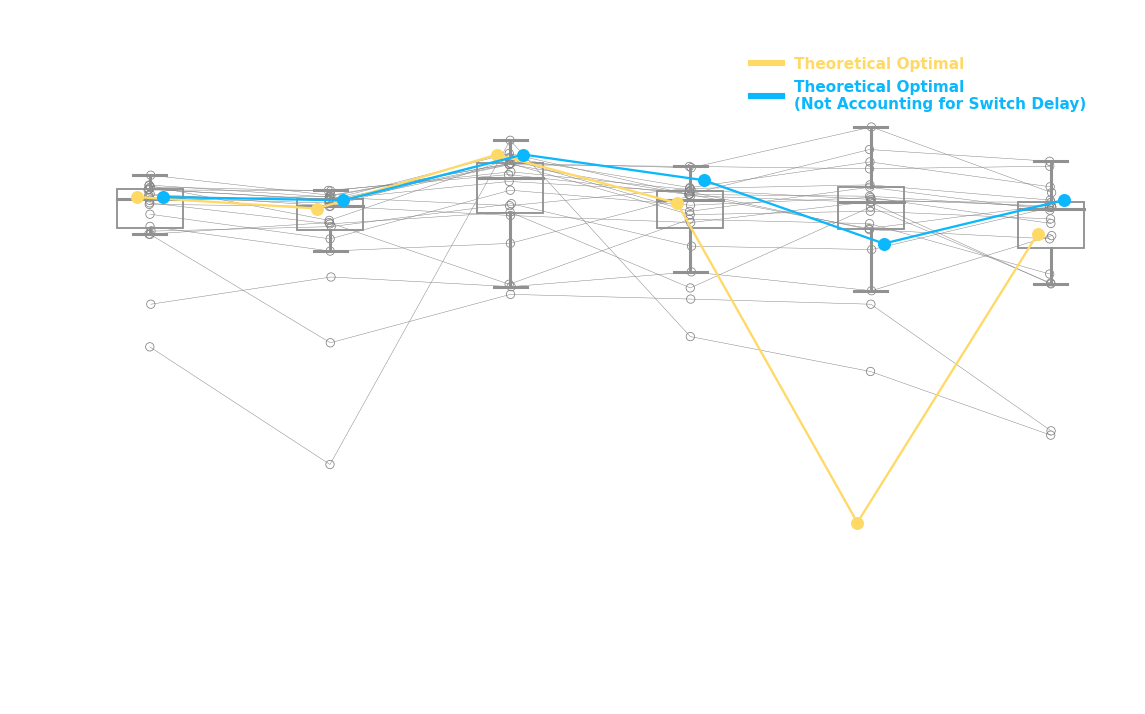

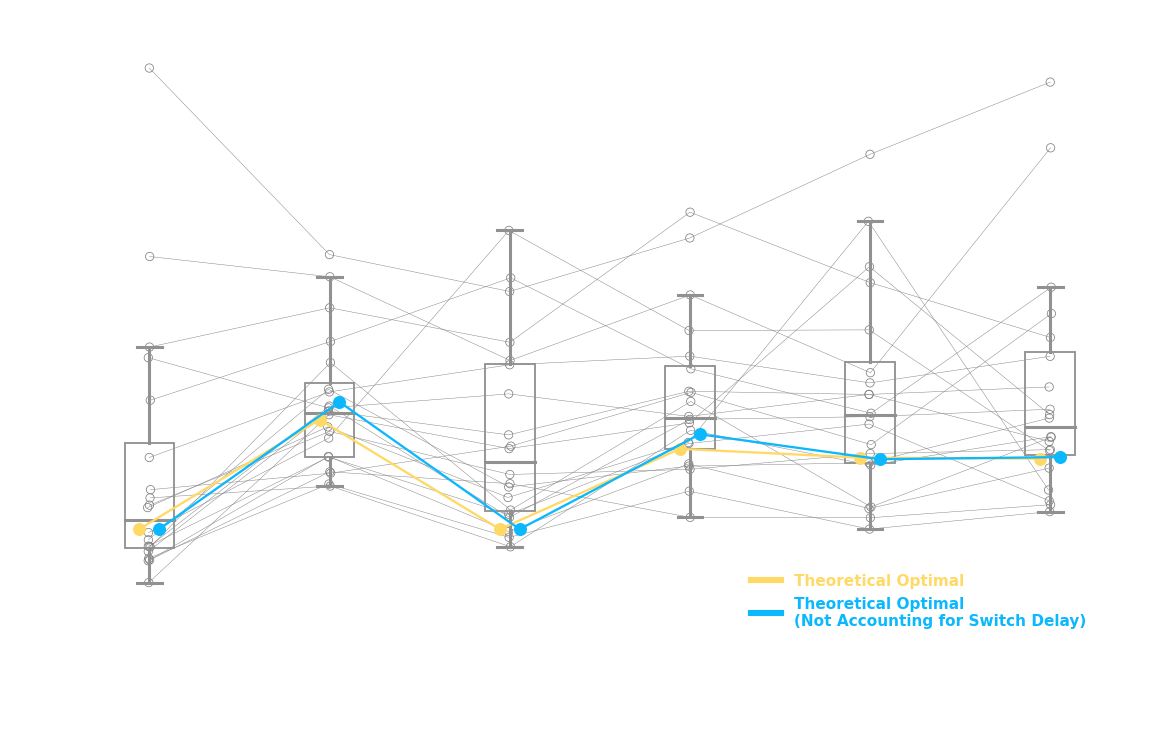

In [183]:
if True:
    xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
    legend_fontsize = 10

    metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    ylocs = np.arange(200, 1601, 200)
    ylabel = 'Time (ms)'
    title = 'Median Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in models.values()]
    print(model_data)
    pf.multiple_models_boxplot_v2(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            labels=list(models.keys()),
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=20
        )
    ax.set_ylim(200,1600)
    fig.remove_figure_borders()
if True:
    xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
    legend_fontsize = 10

    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    ylocs = np.arange(0, 201, 50)
    ylabel = 'Time (ms)'
    title = 'SD Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal') for model in models.values()]

    bw = 0.3*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width

    pf.multiple_models_boxplot_v2(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            labels=list(models.keys()),
            show_boxplot=True,
            colors=wheel.grey,
            linestyles=None,
            line_colors = None,
            xlocs=xlocs,
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            title_fontsize=20
        )

### Wins

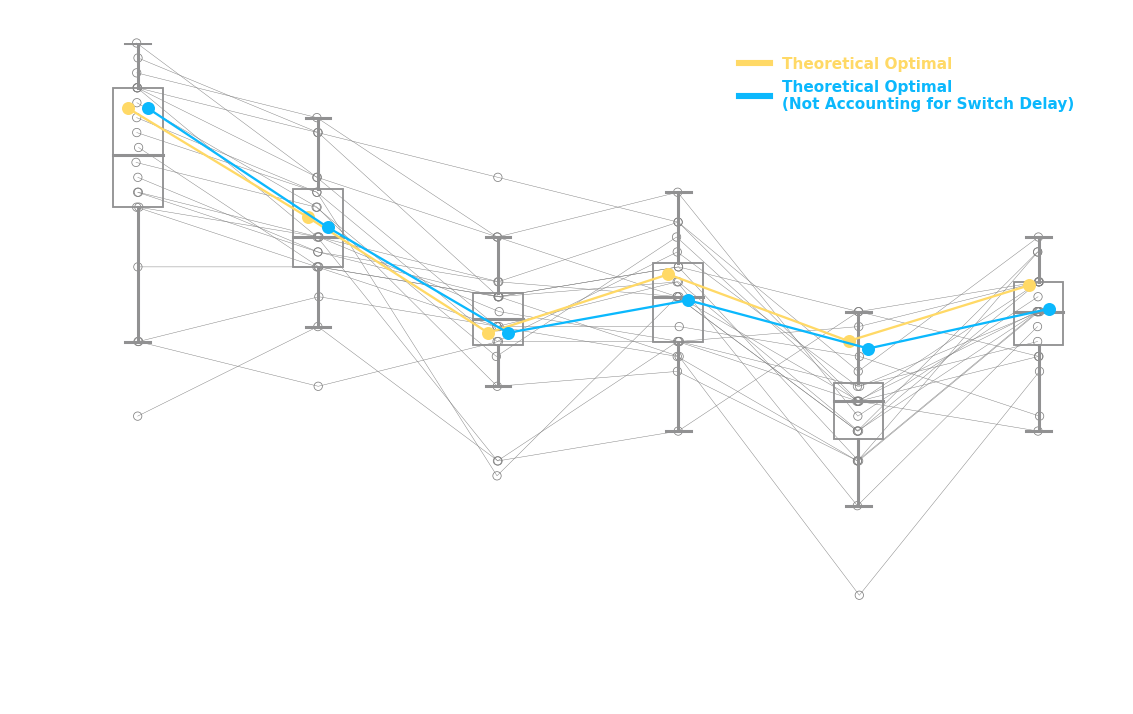

In [184]:
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 10

metric = group.score_metrics.score_metric('wins')*100/group.exp_info.num_task_trials
ylocs = np.arange(0, 101, 25)
ylabel = 'Time (ms)'

fig = dv.Figure(figsize=(w, h), dpi=110)
ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
model_data = [model.results.get_metric(model.score_metrics.prob_win ,metric_type='true',decision_type='optimal')*100 for model in models.values()]

pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        box_width = bw,
        model_data=model_data,
        show_boxplot=SHOW_BOXPLOTS,
        show_models=SHOW_MODELS,
        labels=list(models.keys()),
        colors=wheel.grey,
        linestyles=None,
        line_colors = None,
        xlocs=xlocs,
        ylocs=ylocs,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Percentage (%)',
        title='Wins',
        legend_fontsize=legend_fontsize,
        title_fontsize=20,
    )
ax.set_ylim(-0.5,100)
fig.remove_figure_borders()

### Incorrects

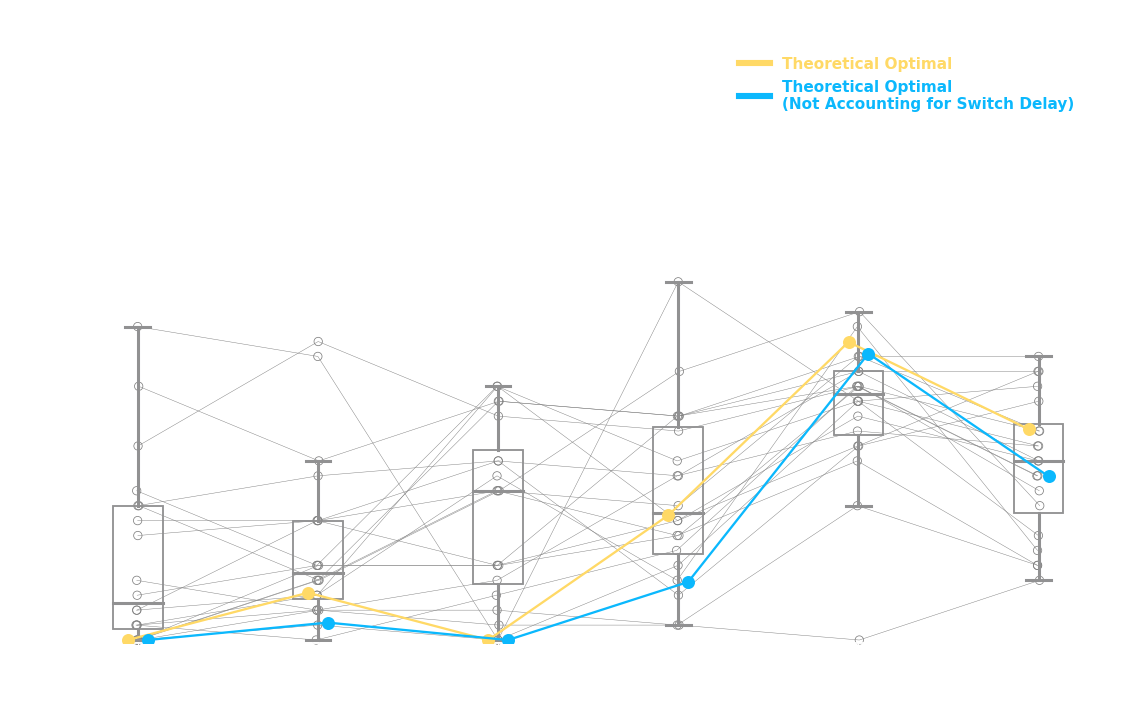

In [185]:
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 10

metric = group.score_metrics.score_metric('incorrects')*100/group.exp_info.num_task_trials
ylocs = np.arange(0, 101, 25)
ylabel = 'Time (ms)'

fig = dv.Figure(figsize=(w, h), dpi=110)
ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
model_data = [model.results.get_metric(model.score_metrics.prob_incorrect ,metric_type='true',decision_type='optimal')*100 for model in models.values()]

pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        box_width = bw,
        model_data=model_data,
        show_boxplot=SHOW_BOXPLOTS,
        show_models=SHOW_MODELS,
        labels=list(models.keys()),
        colors=wheel.grey,
        linestyles=None,
        line_colors = None,
        xlocs=xlocs,
        ylocs=ylocs,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Percentage (%)',
        title='Incorrects',
        legend_fontsize=legend_fontsize,
        title_fontsize=20,
    )
ax.set_ylim(-0.5,100)
fig.remove_figure_borders()

Indecisions

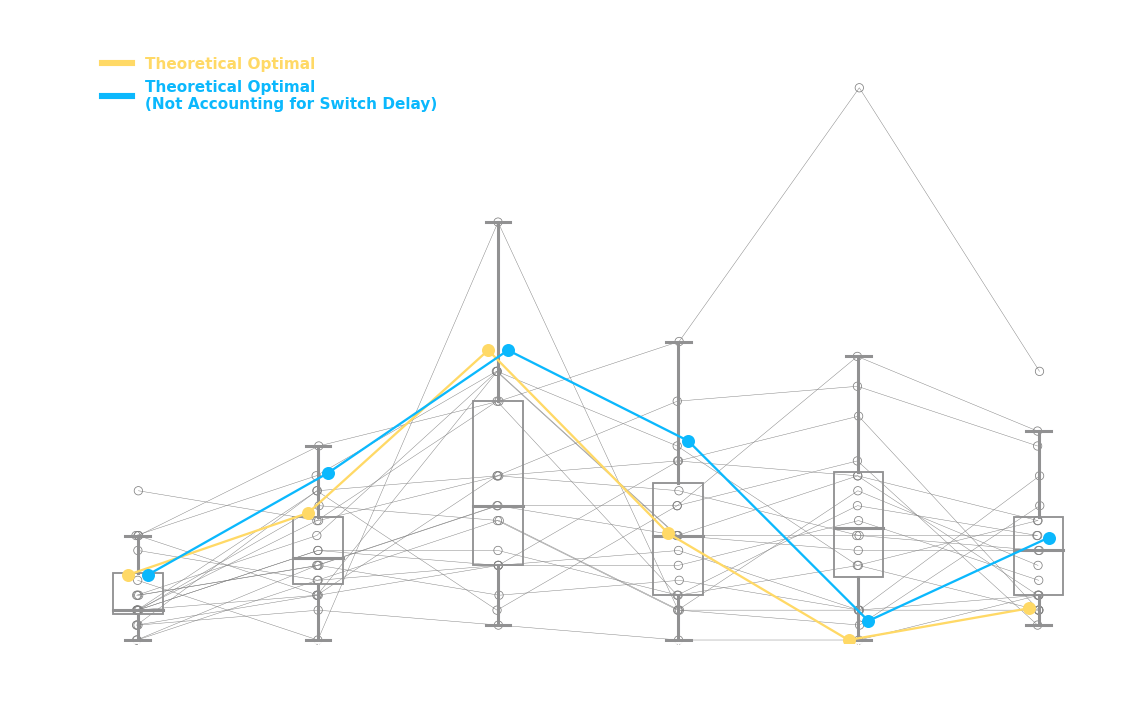

In [186]:
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
legend_fontsize = 10

metric = group.score_metrics.score_metric('indecisions')*100/group.exp_info.num_task_trials
ylocs = np.arange(0, 101, 25)
ylabel = 'Time (ms)'

fig = dv.Figure(figsize=(w, h), dpi=110)
ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
model_data = [model.results.get_metric(model.score_metrics.prob_indecision ,metric_type='true',decision_type='optimal')*100 for model in models.values()]
pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        box_width = bw,
        model_data=model_data,
        show_boxplot=SHOW_BOXPLOTS,
        show_models=SHOW_MODELS,
        labels=list(models.keys()),
        colors=wheel.grey,
        linestyles=None,
        line_colors = None,
        xlocs=xlocs,
        ylocs=ylocs,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Percentage (%)',
        title='Indecisions',
        legend_fontsize=legend_fontsize,
        title_fontsize=20,
    )
ax.set_ylim(-0.5,100)
fig.remove_figure_borders()

In [187]:
model_data

[array([10.89794947, 21.27566305, 48.54427229, 17.8413471 ,  0.        ,
         5.30705223]),
 array([10.89794946, 27.95785088, 48.54422968, 33.35927208,  3.19967224,
        17.13837687])]